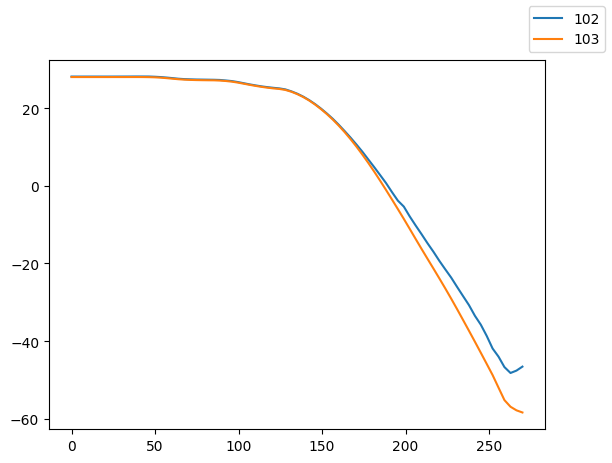

In [9]:
import json
import numpy as np
import matplotlib.pyplot as plt

with open('扫描数据-2023-08-29-00-25-23.json','r',encoding='utf-8') as f:
    data:dict = json.load(f)

ax,fig = plt.subplots(1,1)



for k,v in data.items():

    data = np.array(v['data'])
    time0 = np.array(v['time'])-v['time'][0]
    # 添加新的曲线
    fig.plot(time0,data,label=k)
    if k=='103':
        break


ax.legend()
plt.show()





In [ ]:
import datetime
import pyvisa
import time
import numpy as np
from loguru import logger


# TODO: 直接读取通道数据
# TODO: 修改数据存储结构
# 懒癌犯了不想改了（理直气壮

class Agilent34970A():
    '''
    Agilent34970A 仪器控制
    '''

    def __init__(self) -> None:

        self.scanInterval:int = 10
        self.channelListDict:dict = {}               # 用于保存通道数据
        self.channelListStr:str = str()
        self.physicalType:list = []
        self.channelList:list = []
        self.unitsList:list = []
        self.connectState:bool = False
        self.session = None
        self.rm = pyvisa.ResourceManager()
        ...

    @property
    def getComList(self):
        return self.rm.list_resources()
    
    @property
    def getInstId(self) -> str:
        return self.inst.query("*idn?")
    @property
    def getInstSession(self):
        return self.inst.session
    @property
    def closeInstrument(self):
        self.inst.close()
        self.connectState = False
        ...

    def connectInstrument(self,com:str, baude_rate: str ,timeout:str, **kargs)->str:
        id = '未获取到id'
        try:
            self.inst = self.rm.open_resource(com)
            self.session = self.getInstSession
            self.inst.read_termination = '\n'    # 读取终止符
            self.inst.write_termination = '\n'   # 写入终止符
            self.inst.baude_rate = int(baude_rate)       #波特率
            self.inst.timeout = int(timeout)           #超时时间

            self.connectState = True            # 连接状态           
            if 'scanInterval' in kargs.keys():   
                self.scanInterval = kargs['scanInterval']-0.1   #扫描间隔
            if 'reset' in kargs.keys() and kargs['reset']:
                self.inst.write("*RST")                     # 重置仪器
                time.sleep(0.1)
            if 'cls' in kargs.keys() and kargs['cls']:
                self.inst.write("*CLS")                     # 清除仪器状态
                time.sleep(0.1)
            id = self.getInstId             # 获取仪器id
            return id                
        except Exception as e:
            if self.connectState:
                self.inst.write("*CLS")                 # 清除仪器状态
            return str(e)

    def testInst(self,**kargs):
        if 'timeout' in kargs.keys():
            self.inst.timeout = kargs['timeout']
        try:
            tst = self.inst.query("*tst?")
            if '0' in  tst:
                return 'passed'
            else:
                return 'failed'
        except Exception as e:
            self.inst.write("*CLS")
            return e
    
    def confTemp(self, 
                 probeType: int = 1,
                 sensorType: str = 'K',
                 channelListStr: str = '',
                 temperatureUnit: str = 'C'):
        '''
        配置温度通道
        ---
        ProbeType[int]: 1: 热电偶[default] 2: 热敏电阻 3: 热电阻 4: 四线热电阻\n
        SensorType[str]: 热电偶: 'B','E','J','K'[default],'N','R','S','T','U'\n
                         热敏电阻: '2252', '5000', '10000'\n
                         热电阻/4线热电阻: '85', '91'\n
        Channel_list[str]: 通道列表, 以","分隔，连续通道以":"分隔，例如: '101,102' '101:110'\n
        TemperatureUnit[str]: 温度单位, 'C'[default],'F','K'\n

        '''
        # logger.info(
        #     '\n 配置温度通道:' +\
        #     '通道: ' + str(channelListStr) + '\n' +\
        #     '单位: ' + str(temperatureUnit) + '\n' +\
        #     '类型: ' + str(probeType) + '\n' +\
        #     '传感器类型: ' + str(sensorType)
        # )
        # 1-热电偶 2-热敏电阻 3-热电阻 4-4线热电阻
        if probeType == 1:
            probeType = 'TCouple'
        elif probeType == 2:
            probeType = 'THERmistor' 
        elif probeType == 3:
            probeType = 'RTD'
        elif probeType == 4:
            probeType = 'FRTD'
        else:
            return 'ProbeType Error'
        self.channelListStr = self.channelListStr+','+channelListStr
        _unitsList = [temperatureUnit]*len(channelListStr.split(','))
        # _typeList = [probeType]*len(channelListStr.split(','))
        _typeList = ['温度']*len(channelListStr.split(','))
        self.addNewChannel(channelListStr, _unitsList, _typeList)
        # 配置通道
        self.inst.write("CONF:TEMP %s,%s,(@%s)"%(probeType ,sensorType ,channelListStr))
        self.inst.write("UNIT:TEMP %s,(@%s)"%(temperatureUnit ,channelListStr))
        time.sleep(0.1)
        self.getConfig


    def confCurr(self,currType:str='DC',currRange:str='AUTO',channelListStr:str=''):
        '''
        配置电流通道
        ---
        CurrType[str]: 电流类型, 'DC'[default],'AC'\n
        CurrRange[str]: 电流量程, 'AUTO', '10mA', '100mA', '1A'\n
        channelList[str]: 通道列表, 以","分隔，连续通道以":"分隔，例如: '101,102' '101:110'\n
        '''
        self.channelListStr = self.channelListStr+','+channelListStr
        _unitsList = ['mA']*len(channelListStr.split(','))
        # _typeList = [currType]*len(channelListStr.split(','))
        if currType == 'DC':
            _typeList = ['直流电流']*len(channelListStr.split(','))
        elif currType == 'AC':
            _typeList = ['交流电流']*len(channelListStr.split(','))
        self.addNewChannel(channelListStr, _unitsList, _typeList)
        # 配置通道
        if currRange != 'AUTO':
            currRange = str(float(currRange)/1000)
            self.inst.write("CONF:CURR:%s %s,0.001,(@%s)" %(currType ,currRange, channelListStr))
        else:
            self.inst.write("CONF:CURR:%s %s,(@%s)" %(currType ,currRange, channelListStr))
        self.getConfig
        ...
    
    def confCalulated(self, currType:str, currRange:str, channelListStr:str,
                            measureType:str, measureUnits:str,
                            currRangeMax:float,currRangeMin:float,
                            mesureRangeMin:float,mesureRangeMax:float
                            ):
        self.channelListStr = self.channelListStr+','+channelListStr
        _unitsList = [measureUnits]*len(channelListStr.split(','))
        _typeList = [measureType]*len(channelListStr.split(','))
        self.addNewChannel(channelListStr, _unitsList, _typeList ,
                           waitConverted=True,
                           currRangeMin=currRangeMin, currRangeMax=currRangeMax,
                           mesureRangeMin=mesureRangeMin, mesureRangeMax=mesureRangeMax
                           )
        # 配置通道
        if currRange != 'AUTO':
            currRange = str(float(currRange)/1000)
            self.inst.write("CONF:CURR:%s %s,0.001,(@%s)" %(currType ,currRange, channelListStr))
        else:
            self.inst.write("CONF:CURR:%s %s,(@%s)" %(currType ,currRange, channelListStr))
        self.getConfig
        ...
    def transCurrToOther(self, currMeasure:float,                            
                         currRangeMin:float, currRangeMax:float,
                         mesureRangeMin:float, mesureRangeMax:float):
        # 使用线性插值公式
        # 将4-20mA(典型值)转换为相应量程内的其他物理量currRangeMax->mesureRangeMax，currRangeMin->mesureRangeMin
        return mesureRangeMin + (mesureRangeMax - mesureRangeMin) * (currMeasure - currRangeMin) / (currRangeMax - currRangeMin)
        ...

    def scan(self, channelListStr):
        self.inst.write("ROUT:SCAN (@%s)"%channelListStr)
        
        ...
    def read(self):
        time.sleep(0.1)
        result = self.inst.query_ascii_values('READ?',container=np.array)
        return result

    def scanAll(self):
        self.inst.write("ROUT:SCAN (@%s)"%self.channelListStr)
        ...

    @property
    def readResult(self):
        self.inst.write("FORM:READ:TIME ON")
        self.inst.write("FORM:READ:TIME:TYPE ABS")
        time.sleep(0.1)
        scanData = self.inst.query_ascii_values('READ?',container=np.array)
        # logger.info(
        #     '\n 读取数据:' +\
        #     '通道: ' + str(self.channelList) + '\n' +\
        #     '数据: ' + str(scanData) 
        # )
        return scanData
    
    # @property
    def parseResult(self):
        self.scanAll()
        scanResults = self.readResult

        j=0
        for i in range(len(self.channelList)):
            if self.channelListDict[self.channelList[i]]['transPara']:
                data =  self.transCurrToOther(
                    scanResults[j:j+7][0],
                    currRangeMin = self.channelListDict[self.channelList[i]]['transPara']['currRangeMin'],
                    currRangeMax = self.channelListDict[self.channelList[i]]['transPara']['currRangeMax'],
                    mesureRangeMin = self.channelListDict[self.channelList[i]]['transPara']['mesureRangeMin'],
                    mesureRangeMax = self.channelListDict[self.channelList[i]]['transPara']['mesureRangeMax'])
                self.channelListDict[self.channelList[i]]['data'].append(data)
                self.channelListDict[self.channelList[i]]['time'].append(self.transTimeToTimeStamp(scanResults[j:j+7][1:]))
                self.channelListDict[self.channelList[i]]['maxValue'] = max(self.channelListDict[self.channelList[i]]['data'])
                self.channelListDict[self.channelList[i]]['minValue'] = min(self.channelListDict[self.channelList[i]]['data'])
            else:
                self.channelListDict[self.channelList[i]]['data'].append(scanResults[j:j+7][0])
                self.channelListDict[self.channelList[i]]['time'].append(self.transTimeToTimeStamp(scanResults[j:j+7][1:]))
                self.channelListDict[self.channelList[i]]['maxValue'] = max(self.channelListDict[self.channelList[i]]['data'])
                self.channelListDict[self.channelList[i]]['minValue'] = min(self.channelListDict[self.channelList[i]]['data'])
            j+=7
        logger.info(
            '读取数据:' +\
            '通道: ' + str(self.channelList) 
        )
        return self.channelListDict


    @staticmethod
    def transTimeToTimeStamp(timeList)->float:
        sep = ','
        times = sep.join(str(s) for s in timeList)
        timeStamp = datetime.datetime.strptime(times, f"%Y.0,%m.0,%d.0,%H.0,%M.0,%S.%f").timestamp()
        return timeStamp
    
    def test(self):
        time.sleep(2)
        return {"test":1}

    @property
    def breakScan(self):
        self.inst.write("ABORt")
    #     ...
    @property
    def getConfig(self):
        channelConfig = self.inst.query("CONF? (@%s)"%self.channelListStr)
        logger.info(
            '当前配置:' +\
            str(channelConfig) + '\n'
        )
        return channelConfig

    # @property
    # def getBeginStartScanTime(self):
    #     # This query returns the time at the start of the scan. 
    #     # The string returned has the form yyyy,mm,dd,hh,mm,ss.sss:
    #     # Typical Response: 2009,07,26,22,03,10.314
    #     startTime = self.inst.query("SYSTem:TIME:SCAN?").split('.')[0]
    #     # 转化为时间戳
    #     self.startTime = time.mktime(time.strptime(startTime, "%Y,%m,%d,%H,%M,%S"))
    #     return self.startTime

#     def transString(self, channelListStr, unitList, typeList ,channelListDict):
#         '''
#         处理通道字符串
#         '''
#         channelListStr = channelListStr
#         # 定义一个空列表，用于存放最终结果
#         channelResult = []
#         unitResult = []
#         typeResult = []
#         # 用 , 或 : 分割字符串,
#         channelParts = channelListStr.split(",")
#         # 如果存在空字符串，则删除
#         if "" in channelParts:
#             channelParts.remove("")
#             # unitParts.remove("")
#         partsLength = len(channelParts)
#         # 遍历分割后的列表
#         for i in range(partsLength):
#             # 如果包含 : ，则表示是连续的数字
#             if ":" in channelParts[i]:
#                 # 用 : 分割数字，并转换为整数
#                 start, end = channelParts[i].split(":")
#                 # 用 range() 函数生成连续的数字，并添加到结果列表中
#                 channelResult.extend(range(int(start), int(end) + 1))
#                 unitResult.extend([unitList[i]]*len(range(int(start), int(end) + 1)))
#                 typeResult.extend([typeList[i]]*len(range(int(start), int(end) + 1)))
#             else:
#                 # 否则，添加到结果列表中
#                 channelResult.append(int(channelParts[i]))
#                 unitResult.append(unitList[i])
#                 typeResult.append(typeList[i])
#         for i in range(len(channelResult)):
#             channelListDict[channelResult[i]] = {
#                 'data':[],
#                 'type':typeResult[i],
#                 'unit':unitResult[i],
#                 'time':[],
#                 'maxValue':0,
#                 'minValue':0,
#             }
#         return channelListDict, typeResult, unitResult

#     def addNewChannel(self, channelListStr, unitList, typeList,**kwargs):
#         channelListDict = self.channelListDict
#         # 判断是否有新通道
#         channelListStr = channelListStr
#         channelList = list(channelListDict.keys())
#         channelListNew = []
#         channelListNew, typeResult, unitResult = self.transString(channelListStr, unitList, typeList, channelListDict)
#         channelListNew = list(channelListNew.keys())
#         # 对比新旧通道的差异，并且保持原来的顺序
#         channelListAdd = []
#         for i in range(len(channelListNew)):
#             if channelListNew[i] not in channelList:
#                 channelListAdd.append(channelListNew[i])
#         waitConverte = kwargs.get('waitConverted', None)
#         if waitConverte:
#             currRangeMin = kwargs.get('currRangeMin')
#             currRangeMax = kwargs.get('currRangeMax')
#             mesureRangeMin = kwargs.get('mesureRangeMin')
#             mesureRangeMax = kwargs.get('mesureRangeMax')
#         for i in range(len(channelListAdd)):
#             transPara = None
#             if waitConverte:
#                 transPara = {
#                     'currRangeMin':currRangeMin,
#                     'currRangeMax':currRangeMax,
#                     'mesureRangeMin':mesureRangeMin,
#                     'mesureRangeMax':mesureRangeMax
#                 }
#             channelListDict[channelListAdd[i]] = {
#                 'data':[],
#                 'type':typeResult[i],
#                 'unit':unitResult[i],
#                 'time':[],
#                 'maxValue':0,
#                 'minValue':0,
#                 'transPara':transPara
# ,
#             }
#         channelListDict = dict(sorted(channelListDict.items(), key=lambda x: x[0], reverse=False))
#         sep = ','
#         self.channelListStr = sep.join(str(k) for k in channelListDict.keys())
#         self.channelList = list(channelListDict.keys())
#         self.channelListDict = channelListDict
#         _unitsList=[]
#         _physicalType=[]
#         for k,v in channelListDict.items():
#             _unitsList.extend([v['unit']])
#             _physicalType.extend([v['type']])
#         self.unitsList = _unitsList
#         self.physicalType = _physicalType
#         # logger.info(
#         #     '\n 写入通道配置:' +\
#         #     '通道: ' + str(self.channelListStr) + '\n' +\
#         #     '单位: ' + str(self.unitsList) + '\n' +\
#         #     '类型: ' + str(self.physicalType) + '\n'
#         # )

#     # def saveData(self):
#     #     with open('scanData.json','w') as f:
#     #         f.write(str(self.channelListDict))
#     #     ...
    


# # if __name__ == 'main':
# #     AG = Agilent34970A()
# #     print(AG.getComList())
# #     id = AG.connectInstrument(AG.getComList()[-1],9600,20000,reset=True,cls=True,ScanInterval=10)
# #     print(id)
# #     print(AG.testInst())



In [ ]:
import json
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# 绘制图像
# 读取json数据
with open(r'dist\扫描数据-2023-09-14-16-43-21.json','r',encoding='utf-8') as f:
    data:dict = json.load(f)